In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import npts

### Download data 

In [2]:
# month_ends = pd.date_range(start='1995-12-31', end=pd.datetime.today(), freq='M')
# month_starts = month_ends + pd.Timedelta('1d')
# month_ends = month_ends[1:]
# month_starts = month_starts[:-1]

# tides = pd.DataFrame()
# for start, end in zip(month_starts, month_ends):
#     start_str = f'{start.year}{start.month:02d}{start.day:02d}'
#     end_str = f'{end.year}{end.month:02d}{end.day:02d}'
    
#     print(f'downloading from {start_str} to {end_str}')
    
#     df = pd.read_csv(f'https://tidesandcurrents.noaa.gov/api/datagetter?product=water_level'+
#                 f'&application=NOS.COOPS.TAC.WL&begin_date={start_str}&end_date={end_str}&'+
#                 f'datum=MLLW&station=9415020&time_zone=lst&units=metric&format=csv', index_col=0)
    
#     tides = pd.concat([tides, df])

# tides.index = pd.to_datetime(tides.index)
# tides.to_csv(f'point_reyes_tides_{start_str}_{end_str}.csv.gz', compression='gzip')

### Load data from disk 

In [3]:
tides = pd.read_csv('point_reyes_tides_20180101_20180131.csv.gz', parse_dates=[0], index_col=0, usecols=[0,1,7])

I couldn't find the specification of the data. I assume the Quality field (which has values "p" and "v") stands
for "preliminary" and "verified". I discard preliminar data.

In [4]:
water_level = tides[tides[' Quality '] == 'v'][' Water Level']
del tides

### Make independent test set 

In [6]:
print('we have years:', set(water_level.index.year))
data_used = water_level[water_level.index.year <= 2015]
indep_test = water_level[water_level.index.year > 2015]

we have years: {1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}


In [13]:
import time

def constant_model(data, test):
    s = time.time()
    mean = np.mean(data)
    took_time = time.time() - s
    rmse = np.sqrt(np.mean((test - mean)**2))
    return rmse, took_time

def model_test_rmse(model, test):
    pred = model.predict(test.index)
    res = test - pred
    return np.sqrt(np.mean(res**2))
    
def daily_avg_model(data, test):
    s = time.time()
    model = data.groupby(data.index.hour).mean()
    took_time = time.time() - s
    rmse = np.sqrt(((test - model[test.index.hour].values)**2).mean(skipna=False))
    return rmse, took_time

def annual_avg_model(data, test):
    s = time.time()
    model = data.groupby(data.index.dayofyear).mean()
    took_time = time.time() - s
    rmse = np.sqrt(((test - model[test.index.dayofyear].values)**2).mean(skipna=False))
    return rmse, took_time

def daily_annual_avg_model(data, test):
    s = time.time()
    model = data.groupby((data.index.hour, data.index.dayofyear)).mean()
    took_time = time.time() - s
    rmse = np.sqrt(((test - model[zip(test.index.hour, test.index.dayofyear)].values)**2).mean(skipna=False))
    return rmse, took_time

def daily_annual_bas_model(data, test):
    s = time.time()
    model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20)),
                          npts.DayOfYear(lambdas=np.logspace(-6,2, 20)))
    model.fit(data)
    took_time = time.time() - s
    return model_test_rmse(model, test), took_time

def daily_annual_lunar_bas_model(data, test):
    s = time.time()
    model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 10)),
                          npts.DayOfYear(lambdas=np.logspace(-6,2, 10)),
                         npts.LunarPhase(n_periods=8,lambdas=np.logspace(-6,2, 10)))
    model.fit(data)
    took_time = time.time() - s
    return model_test_rmse(model, test), took_time


In [16]:
np.random.seed(0)
indep_test_rmse = pd.DataFrame()
time_taken_df = pd.DataFrame()

for data, dataname in [(data_used, 'full data'), 
                       #(data_used[np.random.uniform(size=len(data_used)) < .5], '50% data'),
                      #(data_used[np.random.uniform(size=len(data_used)) < .1], '10% data'),
                      #(data_used[np.random.uniform(size=len(data_used)) < .01], '1% data'),
                      (data_used[np.random.uniform(size=len(data_used)) < .001], '0.1% data'),
                      #(data_used[np.random.uniform(size=len(data_used)) < .0001], '0.01% data')
                      ]:
    for model, modelname in [(constant_model, 'constant'), 
                             (daily_avg_model, 'daily avg.'),
                            (annual_avg_model, 'annual avg.'),
                            (daily_annual_avg_model, 'daily-annual avg.'),
                            (daily_annual_bas_model, 'daily-annual bas.'),
                             (daily_annual_lunar_bas_model, 'daily-annual-lunar bas.')
                            ]:
        rmse, time_taken = model(data, indep_test)
        indep_test_rmse.loc[dataname, modelname] = rmse
        time_taken_df.loc[dataname, modelname] = time_taken

building reg matrices
building reg matrices


/Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


building reg matrices
building reg matrices


KeyboardInterrupt: 

In [17]:
indep_test_rmse

,constant,daily avg.,annual avg.,daily-annual avg.,daily-annual bas.,daily-annual-lunar bas.
full data,0.523762,0.515115,0.521994,0.442835,0.442425,0.247214
0.1% data,0.523544,0.517710,NaN,NaN,0.453677,NaN


In [18]:
time_taken_df

,constant,daily avg.,annual avg.,daily-annual avg.,daily-annual bas.,daily-annual-lunar bas.
full data,0.010789,0.549988,0.544191,1.085270,41.653756,472.471582
0.1% data,0.000146,0.002627,0.001699,0.003535,20.134262,NaN


## Baseline 

In [7]:
# import datetime

# class LunarPhase(npts.features.Feature):

#     def __init__(self, n_periods = 8, **kwargs):
#         super().__init__(**kwargs)
#         self.n_periods = n_periods
        
#     def lunations(self, timestamp): 
#         """Lunations since Jan 1, 2001."""
#         diff = timestamp - datetime.datetime(2001, 1, 1)
#         days = diff.days + diff.seconds / 86400
#         return 0.20439731 + days * 0.03386319269

#     def indexer(self, index, column=None):
#         lunations = self.lunations(index)
#         return (np.floor(self.n_periods*lunations + .5).astype(int) % self.n_periods)

In [8]:
test = water_level[-len(water_level)//20:]
train = water_level[:-len(water_level)//20]

In [9]:
train = water_level[:len(train)//6]

In [11]:
baseline = npts.Baseline(npts.IntervalOfDay('6min'),#, lambdas=np.logspace(-5,-2, 5)), 
                         npts.MonthOfYear(),##lambdas=np.logspace(-9,-2, 5)), 
                         npts.LunarPhase(n_periods=48))#, lambdas=np.logspace(-8,-2, 5)))#np.logspace(-22,-18, 4)))

Building baseline with 138240 =  240*12*48 values.
building reg matrices


In [12]:
baseline.fit(train, compute_tr_costs=True)

Fitting on 303579 observations, of dimension 1
Train set: 242951 obs. Test set : 60628 obs.
Making quadratic loss term for 242951 obs.
Making quadratic loss term for 60628 obs.
Provided lambdas: [[None], [None], [None]]
working with lambda (None, None, None)
numerically optimizing on 3 dims
solving with λ=(1.0000072338224604, 1.0000072338224604, 1.0000072338224604)
mat [[ 6.00005164 -1.00000723  0.          0.          0.        ]
 [-1.00000723  6.00005164 -1.00000723  0.          0.        ]
 [ 0.         -1.00000723  6.00005575 -1.00000723  0.        ]
 [ 0.          0.         -1.00000723  6.00005575 -1.00000723]
 [ 0.          0.          0.         -1.00000723  6.00005164]]
rhs [[  1.21423662e-05]
 [  1.09281295e-05]
 [  1.73491774e-05]
 [  1.70322411e-05]
 [  1.19118670e-05]]
CG took 0.9890172481536865 seconds.
(60628, 1)
(242951, 1)
Val. cost: 2.815e-01
computing gradient of test cost in the lambdas
CG took 0.8605420589447021 seconds.
grad of val. cost in the lambdas [  6.274371

CG took 0.004644870758056641 seconds.
grad of val. cost in the lambdas [  6.27437109e-05   4.33471328e-06   3.18413700e-05]
numerical gradient of val cost in u: [  6.27441648e-05   4.33474463e-06   3.18416003e-05]
solving with λ=(1.0000072334471442, 1.0000072337965311, 1.0000072336319938)
mat [[ 6.00005163 -1.00000723  0.          0.          0.        ]
 [-1.00000723  6.00005163 -1.00000723  0.          0.        ]
 [ 0.         -1.00000723  6.00005575 -1.00000723  0.        ]
 [ 0.          0.         -1.00000723  6.00005575 -1.00000723]
 [ 0.          0.          0.         -1.00000723  6.00005163]]
rhs [[  1.21423662e-05]
 [  1.09281295e-05]
 [  1.73491774e-05]
 [  1.70322411e-05]
 [  1.19118670e-05]]
CG took 0.004655122756958008 seconds.
(60628, 1)
(242951, 1)
Val. cost: 2.815e-01
computing gradient of test cost in the lambdas
CG took 0.0037560462951660156 seconds.
grad of val. cost in the lambdas [  6.27437109e-05   4.33471328e-06   3.18413700e-05]
numerical gradient of val cost 

In [13]:
# baseline.val_costs

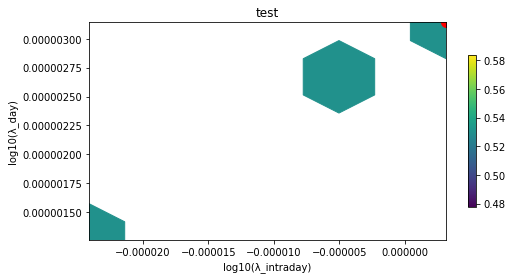

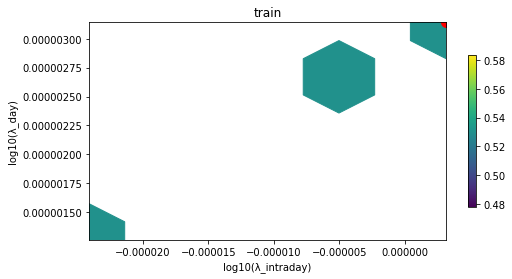

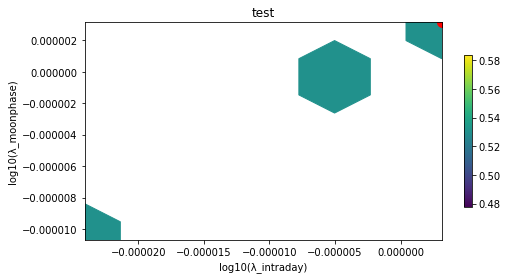

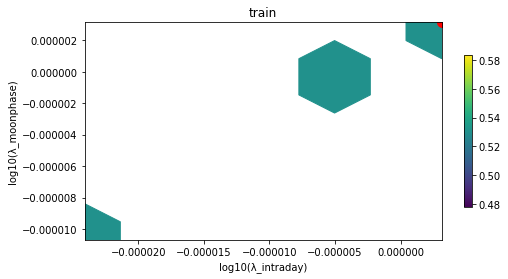

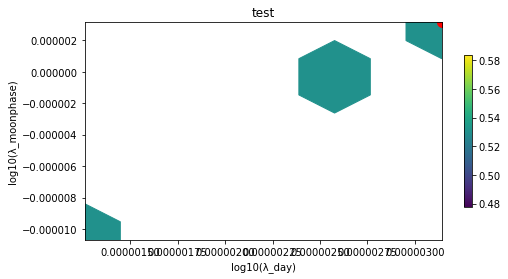

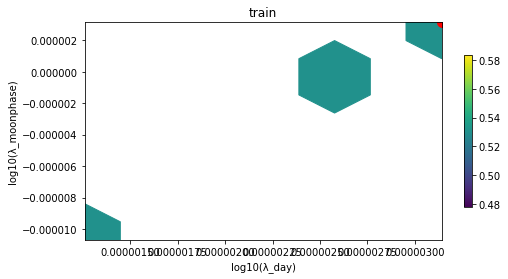

In [14]:
import matplotlib.pyplot as plt
def plot_RMSE(baseline):
    ref = ['intraday', 'day', 'moonphase']
    for pat in [[0,1], [0,2], [1,2]]:
        for cost_dict, title in [[baseline.val_costs, 'test'], 
                                 [baseline.tr_costs, 'train']]:
            fig = plt.figure(figsize=(8,4))
            cax = plt.hexbin(*np.array([[*(np.log10(k)[pat]), np.sqrt(v)] for k, v 
                                  in cost_dict.items()]).T,
                      gridsize=5)
            axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
            plt.plot(*np.log10(baseline.best_lambda)[pat], 'ro', markersize=10)
            plt.xlabel(f'log10(λ_{ref[pat[0]]})')
            plt.ylabel(f'log10(λ_{ref[pat[1]]})')
            plt.title(title)
    
plot_RMSE(baseline)

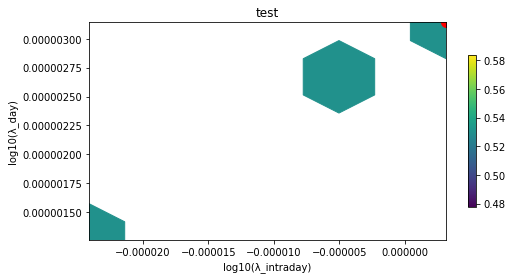

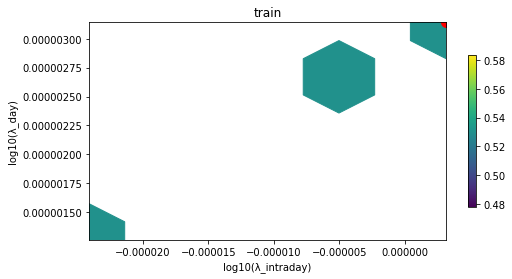

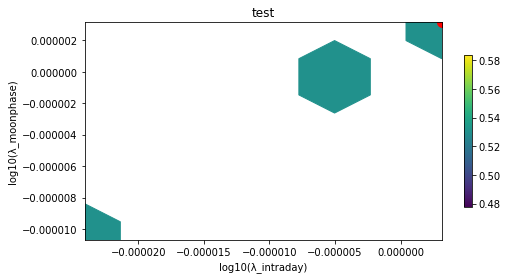

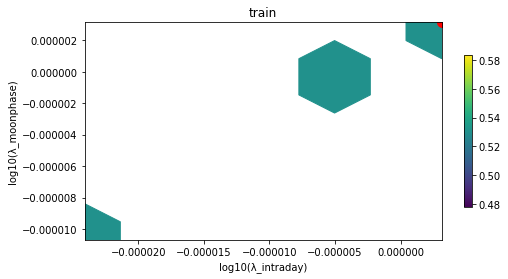

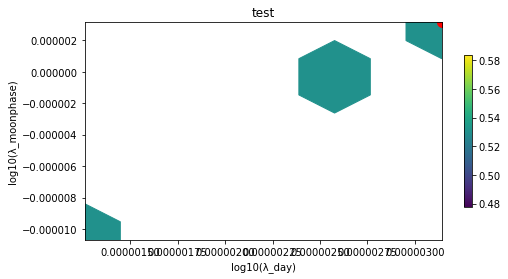

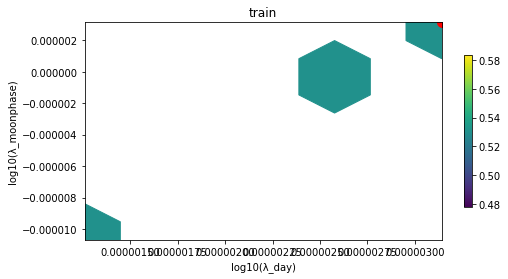

In [15]:
import matplotlib.pyplot as plt
def plot_RMSE(baseline):
    ref = ['intraday', 'day', 'moonphase']
    for pat in [[0,1], [0,2], [1,2]]:
        for cost_dict, title in [[baseline.val_costs, 'test'], 
                                 [baseline.tr_costs, 'train']]:
            fig = plt.figure(figsize=(8,4))
            cax = plt.hexbin(*np.array([[*(np.log10(k)[pat]), np.sqrt(v)] for k, v 
                                  in cost_dict.items()]).T,
                      gridsize=5)
            axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
            plt.plot(*np.log10(baseline.best_lambda)[pat], 'ro', markersize=10)
            plt.xlabel(f'log10(λ_{ref[pat[0]]})')
            plt.ylabel(f'log10(λ_{ref[pat[1]]})')
            plt.title(title)
    
plot_RMSE(baseline)

Text(0,0.5,'moonphase')

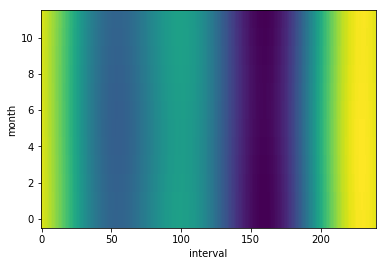

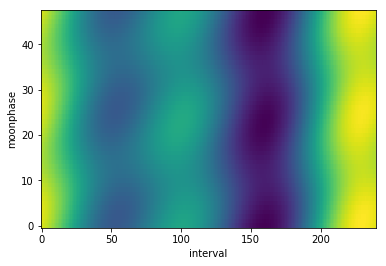

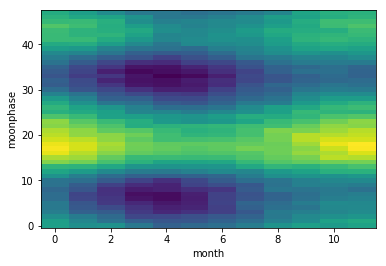

In [16]:
plt.figure()
plt.imshow(np.median(baseline.theta.reshape(*reversed(baseline.n_periods)),0), origin='lower', aspect='auto')
plt.ylabel('month')
plt.xlabel('interval')


plt.figure()
plt.imshow(np.median(baseline.theta.reshape(*reversed(baseline.n_periods)),1), origin='lower', aspect='auto')
plt.ylabel('moonphase')
plt.xlabel('interval')

plt.figure()
plt.imshow(np.median(baseline.theta.reshape(*reversed(baseline.n_periods)),2), origin='lower', aspect='auto')
plt.xlabel('month')
plt.ylabel('moonphase')

In [17]:
baseline.val_costs

{(0.9999444911721641,
  1.000002899055864,
  0.9999753924987124): 0.28149641818865861,
 (0.9999939922224186,
  1.0000063190073745,
  1.0000005139129233): 0.28149641818865861,
 (1.0000044393360668,
  1.0000070407622659,
  1.000005815666996): 0.28149641818865861,
 (1.0000066440830389,
  1.0000071930796994,
  1.0000069345396543): 0.28149641818865861,
 (1.0000071093658731,
  1.0000072252242496,
  1.0000071706628495): 0.28149641818865861,
 (1.0000072075576822,
  1.0000072320079312,
  1.0000072204935304): 0.28149641818865861,
 (1.000007228279542,
  1.000007233439522,
  1.0000072310095232): 0.28149641818865861,
 (1.0000072326527216,
  1.0000072337416477,
  1.0000072332288377): 0.28149641818865861,
 (1.000007232966524,
  1.000007233763327,
  1.0000072333880872): 0.28149641818865861,
 (1.0000072334471442,
  1.0000072337965311,
  1.0000072336319938): 0.28149641818865861,
 (1.0000072334816765,
  1.000007233798917,
  1.0000072336495183): 0.28149641818865861,
 (1.00000723354871,
  1.000007233803548

In [18]:
baseline.val_costs[baseline.best_lambda]

0.28149641818865861

In [19]:
baseline.val_costs[baseline.best_lambda]

0.28149641818865861

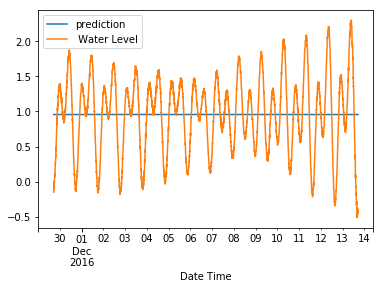

In [20]:
poll = 1822077
win_len = 240*14
window = water_level[poll:poll+win_len]
baseline.predict(window.index).plot(label='prediction', )
window.plot()
import matplotlib.pyplot as plt
plt.legend()

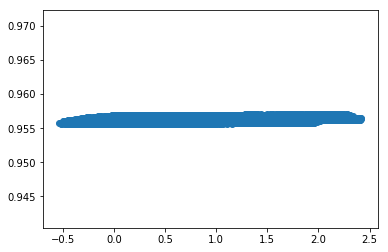

In [21]:
import matplotlib.pyplot as plt
test_pred = baseline.predict(test.index)
plt.scatter(test, test_pred)

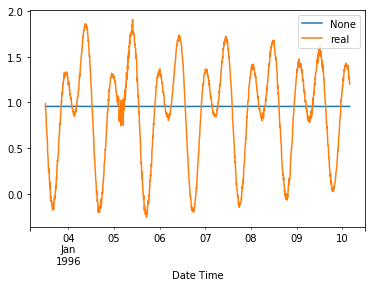

In [22]:
pd.Series(baseline.predict(water_level[600:2200].index), water_level[600:2200].index).plot()
water_level[600:2200].plot(label='real')
plt.legend()

In [31]:
baseline.val_costs

{(1e-06, 1e-20, 1e-22): 0.02795096908219788,
 (1e-06, 1e-20, 2.154434690031878e-21): 0.02795096908219788,
 (1e-06, 1e-20, 4.6415888336127913e-20): 0.02795096908219788,
 (1e-06, 1e-20, 1e-18): 0.02795096908219788,
 (1e-06, 1e-17, 1e-22): 0.02795096908219788,
 (1e-06, 1e-17, 2.154434690031878e-21): 0.02795096908219788,
 (1e-06, 1e-17, 4.6415888336127913e-20): 0.02795096908219788,
 (1e-06, 1e-17, 1e-18): 0.02795096908219788,
 (1e-06, 1e-14, 1e-22): 0.02795096908219788,
 (1e-06, 1e-14, 2.154434690031878e-21): 0.02795096908219788,
 (1e-06, 1e-14, 4.6415888336127913e-20): 0.02795096908219788,
 (1e-06, 1e-14, 1e-18): 0.02795096908219788,
 (1e-06, 1e-11, 1e-22): 0.02795096908219788,
 (1e-06, 1e-11, 2.154434690031878e-21): 0.02795096908219788,
 (1e-06, 1e-11, 4.6415888336127913e-20): 0.02795096908219788,
 (1e-06, 1e-11, 1e-18): 0.02795096908219788,
 (1e-05, 1e-20, 1e-22): 0.026658269055141695,
 (1e-05, 1e-20, 2.154434690031878e-21): 0.026658269055141695,
 (1e-05, 1e-20, 4.6415888336127913e-20):

In [ ]:
def plot_RMSE(cost_dict, title):
    fig = plt.figure(figsize=(8,4))
    cax = plt.hexbin(*np.array([[*np.log(k), np.sqrt(v)] for k, v 
                          in cost_dict.items()]).T,
              gridsize=10)
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
    plt.plot(*np.log(baseline.best_lambda), 'ro', markersize=10)
    plt.xlabel('log(λ_day)')
    plt.ylabel('log(λ_annual)')
    plt.title(title)
    
plot_RMSE(baseline.val_costs, 'test')
plot_RMSE(baseline.tr_costs, 'train')

In [64]:
import datetime

class LunarPhase(npts.features.Feature):

    def __init__(self, n_periods = 8, **kwargs):
        super().__init__(**kwargs)
        self.n_periods = n_periods
        
    def lunations(self, timestamp): 
        """Lunations since Jan 1, 2001."""
        diff = timestamp - datetime.datetime(2001, 1, 1)
        days = diff.days + diff.seconds / 86400
        return 0.20439731 + days * 0.03386319269

    def indexer(self, index, column=None):
        lunations = self.lunations(index)
        return (np.floor(self.n_periods*lunations + .5).astype(int) % self.n_periods)
    
    
# def phase(pos): 
#    index = (pos * dec(8)) + dec("0.5")
#    index = math.floor(index)
#    return {
#       0: "New Moon", 
#       1: "Waxing Crescent", 
#       2: "First Quarter", 
#       3: "Waxing Gibbous", 
#       4: "Full Moon", 
#       5: "Waning Gibbous", 
#       6: "Last Quarter", 
#       7: "Waning Crescent"
#    }[int(index) & 7]

In [63]:
np.floor(-12.2).astype(int)

-13

In [65]:
LunarPhase().indexer(water_level[600:1200].index)

Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='Date Time', length=600)

## Experiments 

In [27]:
import scipy.sparse as sp
import numpy as np

In [32]:
a = np.arange(1000.)
b = np.arange(1000.)

In [33]:
%timeit a*b

960 ns ± 50.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [38]:
%timeit sp.diags(a)@b

65.3 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [40]:
%timeit c = np.array(a)

593 ns ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [41]:
%timeit c = np.array(a, copy=False)

166 ns ± 4.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [42]:
d = np.array([1,2])

In [43]:
%timeit e = np.array(d)

408 ns ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [44]:
%timeit e = np.array(d, copy=False)

155 ns ± 2.16 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [45]:
%timeit e = d

22.2 ns ± 0.931 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
